In [1]:
import os
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import (
    Dense, LSTM, LSTMCell, Dropout
)
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from keras.optimizers import Adam, SGD

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (
    mean_squared_error as mse,
    mean_absolute_error as mae
)
from sklearn.model_selection import train_test_split

from bunch import bunchify

from helpers.model_adam import Model

Using TensorFlow backend.


In [16]:
currency = 'usd'

In [2]:
usd = pd.read_csv('datasets-usd.csv', index_col='Date')
usd.head()

,Price,Open,High,Low
Date,,,,
2014-01-01,12170.0,12170.0,12170.0,12170.0
2014-01-02,12160.0,12195.0,12260.0,12150.0
2014-01-03,12170.0,12160.0,12245.0,12160.0
2014-01-06,12180.0,12195.0,12245.0,12180.0
2014-01-07,12237.5,12197.5,12277.5,12197.5


# Data Single Fitur Configuration

Pada tahap ini data yang diproses hanya fitur data ***Price*** saja. fitur  ***Open***, ***High***, dan ***Low*** diabaikan.

> **Notes**
>
> perform the process of sharing training and test data, then the data will be normalized in standard form. 

## Data spliting (training & testing)

> **Notes**
> Pembagian data training dan testing menggunakan rasio 80% awal untuk training dan 20% terakhir sebagai testing

In [3]:
# split function

def split(data, n_train=0.8, n_test=0.2):
    train_set = data.Price.iloc[:round(n_train*len(data))].values
    test_set = data.Price.iloc[round( n_train*len(data) ):].values
    return train_set, test_set

In [4]:
dataset={}
dataset['train_set'], dataset['test_set'] = split(usd)

## Scaling data with MinMaxFunction [-1, 1]

\begin{equation}
X\_std = \frac{({X} - {X.min(axis=0)})} {(X.max(axis=0) - X.min(axis=0))}\\
\\
X\_scaled = X\_std * (max - min) + min\\
\end{equation}


In [5]:
# define scaler parameter
scaler = MinMaxScaler(feature_range=(-1, 1))

In [6]:
# data set transformation to metric shape (n_data, 1)
dataset['train_set'] = dataset['train_set'].reshape(
    len(dataset['train_set']), 1
)
dataset['test_set'] = dataset['test_set'].reshape(
    len(dataset['test_set']), 1
)

In [7]:
dataset['train_set'].shape, dataset['test_set'].shape

((1447, 1), (362, 1))

In [8]:
# data transformation
dataset['train_set_scaled'] = scaler.fit_transform(dataset['train_set'])
dataset['test_set_scaled'] = scaler.fit_transform(dataset['test_set'])

In [9]:
# convert dict to object

class dict2obj(object):
    def __init__(self, d):
        for a, b in d.items():
            if isinstance(b, (list, tuple)):
                setattr(self, a, [dict2obj(x) if isinstance(x, dict) else x for x in b])
            else:
                setattr(self, a, dict2obj(b) if isinstance(b, dict) else b)

In [10]:
data = dict2obj(dataset)

# Sliding dataset

In [11]:
def sliding_window(data, window, step_size=1):
    X_train=[]
    y_train=[]
    
    for i in range(window, data.shape[0]):
        X_train.append(data[i-window:i])
        y_train.append(data[i])
    X_train, y_train = np.array(X_train), np.array(y_train)
    return X_train, y_train

In [12]:
data.windows={}

In [13]:
inputs = [7,8,9,10]

for window in inputs:
    data.windows[f'X_train{window}'], data.windows[f'y_train{window}'] = sliding_window(
        data=data.train_set_scaled,
        window=window
    )
    data.windows[f'X_test{window}'], data.windows[f'y_test{window}'] = sliding_window(
        data=data.test_set_scaled,
        window=window
    )

In [14]:
data.windows=dict2obj(data.windows)

In [15]:
data.windows.X_train8.shape

(1439, 8, 1)

# Proposed model design and Experiment design
| No. | Hyperparameters | Accuracy |
| :- | -: | :-: |
| 1* | Unit input/Sliding Window | [7,8,9,10] |
| 2* | Unit Neuron/Block LSTM | [1,2,3,4] |
| 3 | Unit Output/Target | 1 |
| 4 | Epochs | 100 |
| 5 | Hidden Layer (Stacked) | 3 |
| 6* | Optimizer | SGD, Adam |
| 7 | Beta Value | B1 = 0,9 & B2 = 0,99 |
| 8* | Learning Rate | 0,1; 0,01; 0,001; 0,0001 |
| 9 | Batch Size | 32 |
| 10* | Dropout | 0%, 20% |
| 11 | Activate Func | sigmoid & tanh |

# Learning Rate 
- eksperimen dilakukan dengan cara mencari learning rate paling sesuai. pengujian dilakukan dengan nilai 1, 0,1, 0,01 dan 0,001 untuk nilai Learning Rate. Parameter lain akan diatur secara konstan, yaitu sliding window sebesar 1, 2 unit neuron pada hidden layer dan epoch maksimum 1000.

In [17]:
data.lr={}
data.lr['X_train'], data.lr['y_train'] = sliding_window(
    data=data.train_set_scaled,
    window=1
)
data.lr['X_test'], data.lr['y_test'] = sliding_window(
    data=data.test_set_scaled,
    window=1
)

In [18]:
data.lr = dict2obj(data.lr)

In [19]:
n_data = data.lr.X_train.shape[0]
X_train = data.lr.X_train[:round(n_data*.8)]
y_train = data.lr.y_train[:round(n_data*.8)]
X_validation = data.lr.X_train[round(n_data*.8):]
y_validation = data.lr.y_train[round(n_data*.8):]

## LR = 1

In [20]:
lr1 = Model()
lr1.set_model(
    name_opt='Adam', 
    input_shape=data.lr.X_train.shape[1],
    neuron_shape=2,
    lr=1
)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 2)                 32        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________
None


In [21]:
lr1.fitting(
    input_set=X_train,
    target_set=y_train,
    val_input=X_validation,
    val_target=y_validation,
    val_epoch=100
)


Train on 1157 samples, validate on 289 samples
Epoch 1/100
1157/1157 [==============================] - 0s 418us/step - loss: 0.2429 - mean_squared_error: 0.2429 - val_loss: 0.4691 - val_mean_squared_error: 0.4691
Epoch 2/100
1157/1157 [==============================] - 0s 86us/step - loss: 0.1416 - mean_squared_error: 0.1416 - val_loss: 0.2568 - val_mean_squared_error: 0.2568
Epoch 3/100
1157/1157 [==============================] - 0s 91us/step - loss: 0.1506 - mean_squared_error: 0.1506 - val_loss: 0.6872 - val_mean_squared_error: 0.6872
Epoch 4/100
1157/1157 [==============================] - 0s 87us/step - loss: 0.1412 - mean_squared_error: 0.1412 - val_loss: 0.6555 - val_mean_squared_error: 0.6555
Epoch 5/100
1157/1157 [==============================] - 0s 84us/step - loss: 0.1430 - mean_squared_error: 0.1430 - val_loss: 0.4608 - val_mean_squared_error: 0.4608
Epoch 6/100
1157/1157 [==============================] - 0s 88us/step - loss: 0.1422 - mean_squared_error: 0.1422 - val_l

In [22]:
model_json = lr1.regressor.to_json()
with open(f"models/{currency}/lr1.json", "w") as json_file:
    json_file.write(model_json)
    
lr1.regressor.save_weights(f"models/{currency}/lr1.h5")
print("model saved!")

model saved!


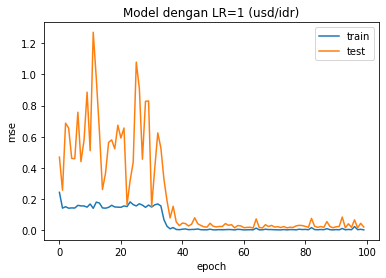

In [23]:
plt.plot(lr1.temp_history.history["mean_squared_error"])
plt.plot(lr1.temp_history.history["val_mean_squared_error"])

plt.title(f'Model dengan LR=1 ({currency}/idr)')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.savefig(f"images/{currency}/lr1.png")

## LR = 0.1

In [24]:
lr01 = Model()
lr01.set_model(
    name_opt='Adam', 
    input_shape=data.lr.X_train.shape[1],
    neuron_shape=2,
    lr=0.1
)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 2)                 32        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
lr01.fitting(
    input_set=X_train,
    target_set=y_train,
    val_input=X_validation,
    val_target=y_validation,
    val_epoch=100
)

Train on 1157 samples, validate on 289 samples
Epoch 1/100
1157/1157 [==============================] - 1s 525us/step - loss: 0.0142 - mean_squared_error: 0.0142 - val_loss: 0.0272 - val_mean_squared_error: 0.0272
Epoch 2/100
1157/1157 [==============================] - 0s 99us/step - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0260 - val_mean_squared_error: 0.0260
Epoch 3/100
1157/1157 [==============================] - 0s 89us/step - loss: 0.0015 - mean_squared_error: 0.0015 - val_loss: 0.0126 - val_mean_squared_error: 0.0126
Epoch 4/100
1157/1157 [==============================] - 0s 96us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 5/100
1157/1157 [==============================] - 0s 96us/step - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 6/100
1157/1157 [==============================] - 0s 102us/step - loss: 0.0012 - mean_squared_error: 0.0012 - val_l

In [26]:
model_json = lr01.regressor.to_json()
with open(f"models/{currency}/lr01.json", "w") as json_file:
    json_file.write(model_json)
    
lr01.regressor.save_weights(f"models/{currency}/lr01.h5")
print("model saved!")

model saved!


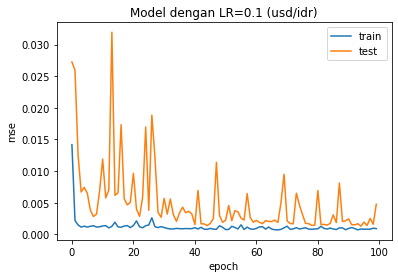

In [27]:
plt.plot(lr01.temp_history.history["mean_squared_error"])
plt.plot(lr01.temp_history.history["val_mean_squared_error"])

plt.title(f'Model dengan LR=0.1 ({currency}/idr)')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.savefig(f"images/{currency}/lr01.png")

## LR = 0.01

In [28]:
lr001 = Model()
lr001.set_model(
    name_opt='Adam', 
    input_shape=data.lr.X_train.shape[1],
    neuron_shape=2,
    lr=0.01
)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 2)                 32        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
lr001.fitting(
    input_set=X_train,
    target_set=y_train,
    val_input=X_validation,
    val_target=y_validation,
    val_epoch=100
)

Train on 1157 samples, validate on 289 samples
Epoch 1/100
1157/1157 [==============================] - 1s 444us/step - loss: 0.0586 - mean_squared_error: 0.0586 - val_loss: 0.1820 - val_mean_squared_error: 0.1820
Epoch 2/100
1157/1157 [==============================] - 0s 100us/step - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0752 - val_mean_squared_error: 0.0752
Epoch 3/100
1157/1157 [==============================] - 0s 98us/step - loss: 0.0025 - mean_squared_error: 0.0025 - val_loss: 0.0552 - val_mean_squared_error: 0.0552
Epoch 4/100
1157/1157 [==============================] - 0s 100us/step - loss: 0.0021 - mean_squared_error: 0.0021 - val_loss: 0.0417 - val_mean_squared_error: 0.0417
Epoch 5/100
1157/1157 [==============================] - 0s 105us/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0354 - val_mean_squared_error: 0.0354
Epoch 6/100
1157/1157 [==============================] - 0s 94us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val

In [30]:
model_json = lr001.regressor.to_json()
with open(f"models/{currency}/lr001.json", "w") as json_file:
    json_file.write(model_json)
    
lr001.regressor.save_weights(f"models/{currency}/lr001.h5")
print("model saved!")

model saved!


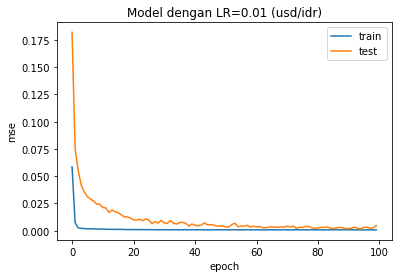

In [31]:
plt.plot(lr001.temp_history.history["mean_squared_error"])
plt.plot(lr001.temp_history.history["val_mean_squared_error"])

plt.title(f'Model dengan LR=0.01 ({currency}/idr)')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.savefig(f"images/{currency}/lr001.png")

## LR = 0.001

In [32]:
lr0001 = Model()
lr0001.set_model(
    name_opt='Adam', 
    input_shape=data.lr.X_train.shape[1],
    neuron_shape=2,
    lr=0.001
)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 2)                 32        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 3         
Total params: 35
Trainable params: 35
Non-trainable params: 0
_________________________________________________________________
None


In [33]:
lr0001.fitting(
    input_set=X_train,
    target_set=y_train,
    val_input=X_validation,
    val_target=y_validation,
    val_epoch=100
)

Train on 1157 samples, validate on 289 samples
Epoch 1/100
1157/1157 [==============================] - 1s 494us/step - loss: 0.1816 - mean_squared_error: 0.1816 - val_loss: 0.5501 - val_mean_squared_error: 0.5501
Epoch 2/100
1157/1157 [==============================] - 0s 93us/step - loss: 0.1712 - mean_squared_error: 0.1712 - val_loss: 0.5568 - val_mean_squared_error: 0.5568
Epoch 3/100
1157/1157 [==============================] - 0s 95us/step - loss: 0.1638 - mean_squared_error: 0.1638 - val_loss: 0.5624 - val_mean_squared_error: 0.5624
Epoch 4/100
1157/1157 [==============================] - 0s 97us/step - loss: 0.1581 - mean_squared_error: 0.1581 - val_loss: 0.5524 - val_mean_squared_error: 0.5524
Epoch 5/100
1157/1157 [==============================] - 0s 96us/step - loss: 0.1535 - mean_squared_error: 0.1535 - val_loss: 0.5464 - val_mean_squared_error: 0.5464
Epoch 6/100
1157/1157 [==============================] - 0s 95us/step - loss: 0.1495 - mean_squared_error: 0.1495 - val_lo

In [34]:
model_json = lr0001.regressor.to_json()
with open(f"models/{currency}/lr0001.json", "w") as json_file:
    json_file.write(model_json)
    
lr0001.regressor.save_weights(f"models/{currency}/lr0001.h5")
print("model saved!")

model saved!


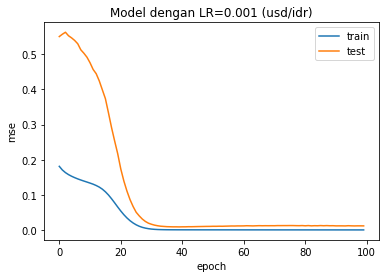

In [35]:
plt.plot(lr0001.temp_history.history["mean_squared_error"])
plt.plot(lr0001.temp_history.history["val_mean_squared_error"])

plt.title(f'Model dengan LR=0.001 ({currency}/idr)')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.savefig(f"images/{currency}/lr0001.png")